# MNIST-pytorch

## Principe :

Choix du Jeu de Données et du Modèle
- problème de classification relativement simple :
- Jeu de données MNIST (classification de chiffres manuscrits) et classification multiclasse (les 26 lettres)
- Modèle de réseau de neurones convolutif (CNN) relativement simple

## Architecture du Modèle

Un réseau de neurones simple avec une couche cachée
Utilise nn.Sequential pour définir l'architecture
Transformation des images en vecteurs plats


Fonctions Principales

- train_model() : Gère l'entraînement sur plusieurs époques
- evaluate_model() : Calcule la précision sur le jeu de test
- main() : Orchestre le chargement des données, l'entraînement et l'évaluation


Particularités

- Utilisation de DataLoader pour le chargement des données
- Normalisation des images
- Sauvegarde du modèle entraîné

Résultats Attendus

- Précision autour de 95-97% sur MNIST
- Temps d'entraînement court (quelques minutes)


## Installation des dépendances système

In [47]:
!pip install torch torchvision matplotlib

## Classe du modèle : MNISTClassifier

## Définition du Modèle

### Import des librairies Permettant de :
- Utiliser les fonctionnalités de base de PyTorch
- Importer des modules pour les réseaux de neurones
- Charger des jeux de données (MNIST)
- Faire des transformations sur les données
- Créer des chargeurs de données


### Définition l'architecture du réseau de neurones : `__init__`
- input_size=784 (28x28 pixels aplatis)
- hidden_size=128 : couche cachée de 128 neurones
- num_classes=10 : 10 classes pour les chiffres de 0 à 9
- learning_rate=0.001
- Utilise un GPU si disponible

- nn.Sequential crée un empilement de couches
- nn.Linear : couches de neurones
- nn.ReLU() : fonction d'activation
- forward() : méthode qui définit la propagation avant, aplatit l'image


### La définition de la fonction d'entrainement : `train_model`

Étapes de l'entraînement :

- Parcourir les époques
- Pour chaque lot de données :
  - Réinitialiser les gradients
  - Faire une prédiction (propagation avant)
  - Calculer l'erreur
  - Calculer les gradients (rétropropagation)
  - Mettre à jour les poids du réseau
- Le modèle garde son état (optimizer, criterion, device)
  
### Fonction d'Évaluation : `evaluate_model`

- Mode évaluation (`model.eval()`)
- `with torch.no_grad()` : pas de calcul de gradient
- Compter les prédictions correctes
- Calculer la précision globale

    def save_model(self, path='mnist_classifier.pth'):
        """
### Fonction  de Sauvegarde les poids du modèle :  `save_model`

### Fonction  de Chargement les poids du modèle : `load_state_dict`

### Fonction  de Faire une prédiction sur de nouvelles données : `predict`
    

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim



class MNISTClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10, learning_rate=0.001):
        super(MNISTClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        
        # Initialisation des composants d'entraînement
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)  # Déplacer le modèle sur GPU si disponible


    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

    def train_model(self, train_loader, num_epochs=5):
        """
        Méthode d'entraînement du modèle
        """
        self.train()  # Mettre le modèle en mode entraînement
        train_losses = []

        
        for epoch in range(num_epochs):
            total_loss = 0.0
            correct = 0
            total = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                # Déplacer les données sur le même device que le modèle
                data, target = data.to(self.device), target.to(self.device)
                
                # Réinitialiser les gradients
                self.optimizer.zero_grad()
                
                # Propagation avant
                output = self(data)
                
                # Calcul de la perte
                loss = self.criterion(output, target)
                
                # Rétropropagation
                loss.backward()
                
                # Mise à jour des poids
                self.optimizer.step()
                
                # Statistiques
                total_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                
                # Affichage de la progression
                if batch_idx % 100 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], '
                          f'Step [{batch_idx}/{len(train_loader)}], '
                          f'Loss: {loss.item():.4f}')
            
            # Statistiques de l'époque
            epoch_loss = total_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Loss: {epoch_loss:.4f}, '
                  f'Accuracy: {epoch_acc:.2f}%')
                  
        
        return train_losses

    def evaluate_model(self, test_loader):
        """
        Méthode d'évaluation du modèle
        """
        self.eval()  # Mettre le modèle en mode évaluation
        correct = 0
        total = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                _, predicted = torch.max(output.data, 1)
                
                total += target.size(0)
                correct += (predicted == target).sum().item()
                
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(target.cpu().numpy())
        
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        
        return accuracy, predictions, true_labels

    def save_model(self, path='mnist_classifier.pth'):
        """
        Sauvegarder les poids du modèle
        """
        torch.save(self.state_dict(), path)
        print(f"Modèle sauvegardé dans {path}")
    
    def load_model(self, path='mnist_classifier.pth'):
        """
        Charger les poids du modèle
        """
        self.load_state_dict(torch.load(path))
        self.eval()
        print(f"Modèle chargé depuis {path}")
    
    def predict(self, x):
        """
        Faire une prédiction sur de nouvelles données
        """
        # Mettre en mode évaluation
        self.eval()
        with torch.no_grad():
            x = x.to(self.device)
            output = self(x)
            _, predicted = torch.max(output.data, 1)
            return predicted        

## Fonctions de visualisation

### Visualisation des Datasets

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, num_samples=10):
    """
    Visualisation d'un échantillon aléatoire d'images du dataset
    Montre l'image et son label
    """
    plt.figure(figsize=(15, 3))
    
    # Sélectionner un échantillon aléatoire
    indices = np.random.randint(0, len(dataset), num_samples)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Convertir le tenseur en image numpy
        img = image.squeeze().numpy()
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Distribution des classes

In [52]:
def analyze_dataset_distribution(dataset):
    """
    Crée un graphique à barres montrant la distribution des classes
    Permet de vérifier l'équilibre du dataset
    """
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts)
    plt.title('Distribution des Classes')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(unique)
    
    # Afficher le nombre exact
    for i, count in enumerate(counts):
        plt.text(unique[i], count, str(count), ha='center', va='bottom')
    
    plt.show()

### Fonction d'analyse détaillée

In [53]:
def detailed_model_evaluation(model, test_loader):
    """
    Évaluation détaillée avec matrice de confusion et exemples de prédictions
    - Crée une matrice de confusion
    - Visualise les images mal classées
    - Montre où le modèle fait des erreurs
    La matrice de confusion montre où le modèle confond des classes
    Les images mal classées aident à comprendre les limites du modèle
    """
    model.eval()
    
    # Matrices pour stocker les résultats
    confusion_matrix = np.zeros((10, 10), dtype=int)
    misclassified_images = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            # Matrice de confusion
            for t, p in zip(target, predicted):
                confusion_matrix[t.item(), p.item()] += 1
            
            # Collecter les images mal classées
            mask = predicted != target
            for img, true_label, pred_label in zip(data[mask], target[mask], predicted[mask]):
                misclassified_images.append((img, true_label.item(), pred_label.item()))
    
    # Visualiser la matrice de confusion
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    plt.title('Matrice de Confusion')
    plt.colorbar()
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    
    # Ajouter les valeurs dans la matrice
    for i in range(10):
        for j in range(10):
            plt.text(j, i, str(confusion_matrix[i, j]), 
                     horizontalalignment="center", 
                     verticalalignment="center")
    
    plt.tight_layout()
    plt.show()

### Courbe d'apprentissage

In [54]:
def plot_learning_curve(train_losses, val_losses=None, title='Learning Curve'):
    """
    Visualise la courbe d'apprentissage pour un modèle PyTorch.
    
    Args:
        train_losses (list): Liste des pertes d'entraînement pour chaque époque
        val_losses (list, optional): Liste des pertes de validation pour chaque époque
        title (str, optional): Titre du graphique
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Perte d\'entraînement', color='blue')
    
    if val_losses is not None:
        plt.plot(val_losses, label='Perte de validation', color='red')
    
    plt.title(title)
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True)
    plt.show()

# Utilisation du modèle

## Chargement et préparation des données

- Préparer les transformations de données
    - `transforms.Normalize((0.1307,), (0.3081,))` : normalisation des images
- Charger les datasets d'entraînement et de test
    - `batch_size=64` : traiter 64 images à la fois
- Créer des DataLoaders
    - `root='./data'` : chemin pour stocker les données
    - `transform=transform` : fonction de transformation des données (ici normalisation)
    - `train=` : `True` pour les données d'entrainement, et `False` pour les données de test

In [55]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Transformations des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Chargement des données
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Chargement des données de test
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Préparation des loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Visualisation des données

### Visualisation des échantillons d'entraînement 

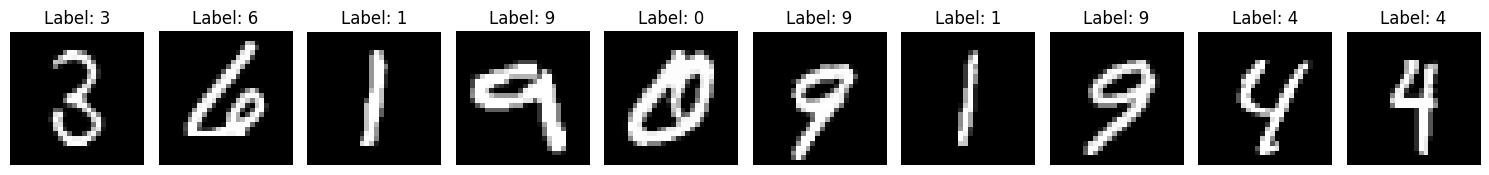

In [56]:
visualize_dataset(train_dataset)

### Visualisation des échantillons de test :

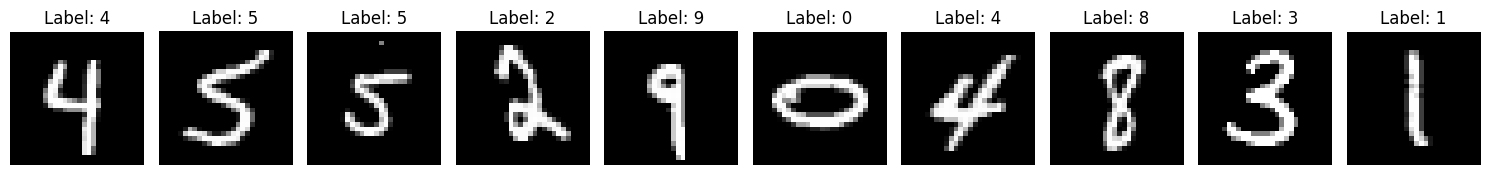

In [57]:
visualize_dataset(test_dataset)

### Distribution des classes

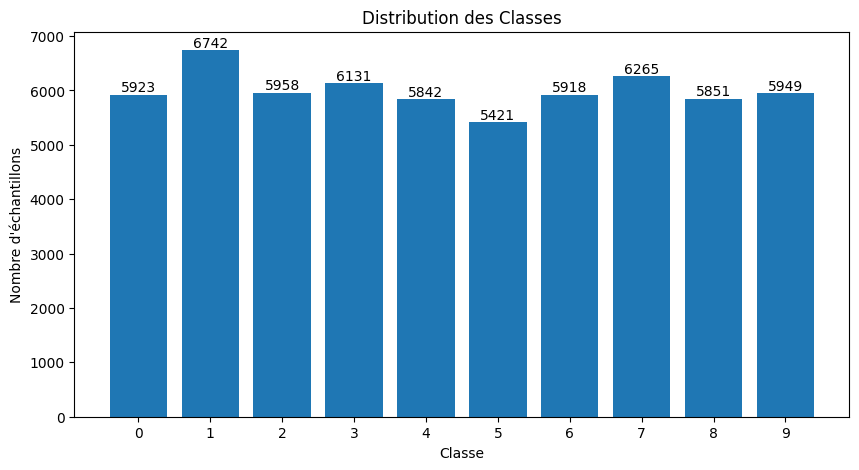

In [58]:
analyze_dataset_distribution(train_dataset)

## Entrainement du modèle

- Initialiser le modèle : appel de la classe `MNISTClassifier`
- Définir la fonction de perte (Cross-Entropy)
  - `nn.CrossEntropyLoss()` : adapté à la classification multiclasse
- Choisir un optimiseur (Adam)
  - `optim.Adam` :
  - `lr=0.001` : taux d'apprentissage
- Entraîner le modèle
  
 
  

In [59]:
# Créer et entraîner le modèle
model = MNISTClassifier()
    
# Entraînement
train_losses = model.train_model(train_loader)


Epoch [1/5], Step [0/938], Loss: 2.3953
Epoch [1/5], Step [100/938], Loss: 0.5252
Epoch [1/5], Step [200/938], Loss: 0.2940
Epoch [1/5], Step [300/938], Loss: 0.2881
Epoch [1/5], Step [400/938], Loss: 0.1736
Epoch [1/5], Step [500/938], Loss: 0.1223
Epoch [1/5], Step [600/938], Loss: 0.0949
Epoch [1/5], Step [700/938], Loss: 0.0437
Epoch [1/5], Step [800/938], Loss: 0.1674
Epoch [1/5], Step [900/938], Loss: 0.0960
Epoch [1/5], Loss: 0.2500, Accuracy: 92.73%
Epoch [2/5], Step [0/938], Loss: 0.0748
Epoch [2/5], Step [100/938], Loss: 0.2010
Epoch [2/5], Step [200/938], Loss: 0.0895
Epoch [2/5], Step [300/938], Loss: 0.1122
Epoch [2/5], Step [400/938], Loss: 0.0709
Epoch [2/5], Step [500/938], Loss: 0.0752
Epoch [2/5], Step [600/938], Loss: 0.2024
Epoch [2/5], Step [700/938], Loss: 0.0579
Epoch [2/5], Step [800/938], Loss: 0.2064
Epoch [2/5], Step [900/938], Loss: 0.1602
Epoch [2/5], Loss: 0.1094, Accuracy: 96.77%
Epoch [3/5], Step [0/938], Loss: 0.0996
Epoch [3/5], Step [100/938], Loss: 0

In [60]:
 #plot_learning_curve(train_losses, val_losses)

## Evaluation du modèle

### Précision du modèle

Précision attendue autour de 95-97% 


In [62]:
accuracy, predictions, true_labels = model.evaluate_model(test_loader)

Test Accuracy: 97.71%


### Analyse détaillée des performances 

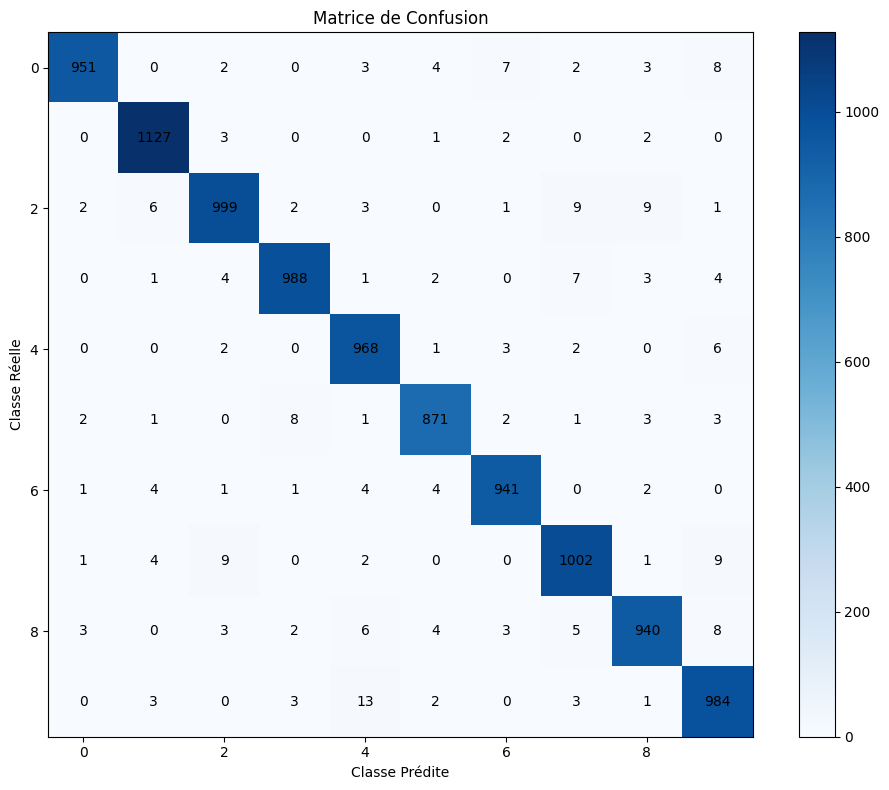

In [63]:
confusion_mat = detailed_model_evaluation(model, test_loader)

## Sauvegarde du modèle

### Sauvegarde des Poids et paramètres du modèle

- sauvegarde dans `mnist_classifier.pth` dans le répertoire courant
- `state_dict()` ne sauvegarde que les poids et paramètres
- Méthode recommandée car plus légère et flexible

In [64]:
# Sauvegarde des paramètres
model.save_model()

Modèle sauvegardé dans mnist_classifier.pth


In [65]:
!ls -l *.pth

-rw-r--r-- 1 ebraux mee-perm 409304 févr.  4 15:09 mnist_classifier.pth


## Prédictions

Initiliasation du modèle avec des poids provenant d'un entrainement

- `demo_prediction` : 
    - Charge un batch de données de test
    - Réalise des prédictions
    - Visualise les résultats avec les prédictions et les vraies étiquettes
- `demo_individual_prediction` :
    - Charge une image, avec possibilité de choisir son index
    - Réalise la prédictions

### Fonctions de prédiction

In [66]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

 
def demo_prediction(model):
    # Configuration
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Charger quelques données de test
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False,
        download=True, 
        transform=transform
    )
    
    # Créer un petit DataLoader pour la démonstration
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
   
    
    # Obtenir un batch de données pour la démonstration
    images, true_labels = next(iter(test_loader))
    
    # Faire des prédictions
    predictions = model.predict(images)
    
    # Visualiser les résultats
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        color = 'green' if predictions[i] == true_labels[i] else 'red'
        plt.title(f'Pred: {predictions[i]}\nVrai: {true_labels[i]}', 
                 color=color, 
                 fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Afficher quelques statistiques
    correct = (predictions == true_labels).sum().item()
    total = len(predictions)
    print(f"Précision sur l'échantillon: {100 * correct / total:.2f}%")
    
    return images, predictions, true_labels

def demo_individual_prediction(model, index=None):
    """
    Faire une prédiction sur une seule image du jeu de test
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Charger le dataset de test
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False,
        download=True, 
        transform=transform
    )
    
    # Si aucun index n'est spécifié, en choisir un au hasard
    if index is None:
        index = torch.randint(0, len(test_dataset), (1,)).item()
    
    # Obtenir une image
    image, true_label = test_dataset[index]
    
    # Faire une prédiction
    prediction = model.predict(image.unsqueeze(0))
    
    # Visualiser l'image et la prédiction
    plt.figure(figsize=(3, 3))
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    color = 'green' if prediction.item() == true_label else 'red'
    plt.title(f'Prédiction: {prediction.item()}\nVrai label: {true_label}', 
             color=color)
    plt.axis('off')
    plt.show()
    
    return prediction.item(), true_label

### Prédiction


Chargement du modèle
Modèle chargé depuis mnist_classifier.pth

Prédictionssur un échantillon


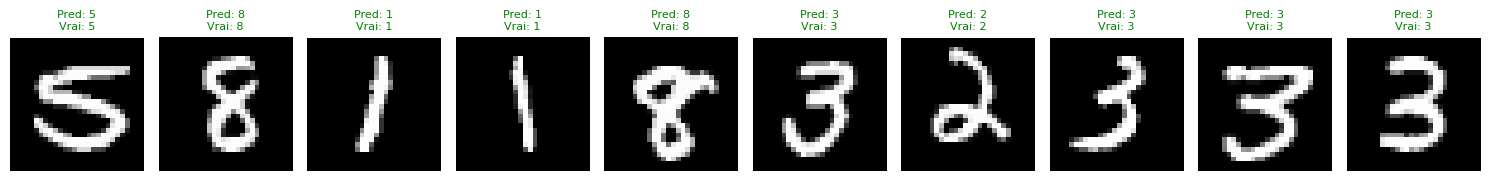

Précision sur l'échantillon: 100.00%

Prédiction sur une image aléatoire


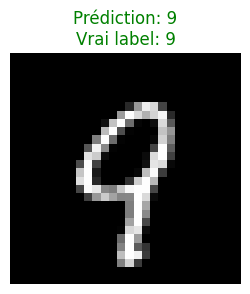

In [67]:
def main():
    
    # Chargement du modèle 
    print("\nChargement du modèle")
    # - Créer une nouvelle instance du modèle
    model = MNISTClassifier()
    # - Charger les poids sauvegardés
    model.load_model('mnist_classifier.pth')

    # Prédictions sur un échantillon
    print("\nPrédictionssur un échantillon")
    images, predictions, true_labels = demo_prediction(model)
    
    # Prédiction individuelle
    print("\nPrédiction sur une image aléatoire")
    pred, true_label = demo_individual_prediction(model)
    
#    # 4. Permettre à l'utilisateur de faire des prédictions sur des images spécifiques
#    while True:
#        try:
#            user_input = input("\nEntrez un numéro d'image (0-9999) ou 'q' pour quitter: ")
#            if user_input.lower() == 'q':
#                break
#            index = int(user_input)
#            if 0 <= index <= 9999:
#                pred, true_label = individual_prediction(model, index)
#            else:
#                print("Veuillez entrer un nombre entre 0 et 9999")
#        except ValueError:
#            print("Entrée invalide")

if __name__ == '__main__':
    main()